# Parameters

In [19]:
destination_folder = './lstm/Model'

# Libraries

In [20]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np

# Data

from data_processing import *
from constants import *
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data.sampler import WeightedRandomSampler

# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Preliminaries

In [22]:
class CainiaoDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __getitem__(self, index):
        row = self.df.iloc[index]
        features = row['x']
        labels = row[LOGISTICS_REVIEW_SCORE]
        return features, labels

    def __len__(self):
        return len(self.df)

In [23]:
# https://www.codefull.net/2018/11/use-pytorchs-dataloader-with-variable-length-sequences-for-lstm-gru/
class PadSequence:
    def __call__(self, batch):
        features = [x[0] for x in batch]
        lengths = torch.LongTensor([len(x[0]) for x in batch])
        labels = torch.LongTensor([x[1] - 1 for x in batch])
        sequences_padded = pad_sequence(features, batch_first=True)
        return sequences_padded, lengths, labels

In [24]:
# Load Data

train_logistics, valid_logistics, test_logistics = load_train_logistics_data(), load_validation_logistics_data(), load_test_logistics_data()
train_order, valid_order, test_order = load_train_order_data(), load_validation_order_data(), load_test_order_data()
train_df, valid_df, test_df = train_logistics.merge(train_order, on=ORDER_ID, how=LEFT), valid_logistics.merge(valid_order, on=ORDER_ID, how=LEFT), test_logistics.merge(test_order, on=ORDER_ID, how=LEFT)
train_df, valid_df, test_df =  train_df.fillna(0), valid_df.fillna(0), test_df.fillna(0)
# pd.get_dummies(subsample_df, columns=[BRAND_ID, CATEGORY_ID, MERCHANT_ID, LOGISTIC_COMPANY_ID, WEEK_COUNT], dtype=pd.Float32Dtype)
train_df, valid_df, test_df = pd.get_dummies(train_df, columns=[ACTION], dtype=float), pd.get_dummies(valid_df, columns=[ACTION], dtype=float), pd.get_dummies(test_df, columns=[ACTION], dtype=float)

# Clean Up Data

dropped_columns = [ITEM_DETAIL_INFO, TIMESTAMP, PAY_TIMESTAMP, BUYER_ID, MERCHANT_ID, LOGISTICS_ORDER_ID]
train_df, valid_df, test_df = train_df.drop(dropped_columns, axis=1), valid_df.drop(dropped_columns, axis=1), test_df.drop(dropped_columns, axis=1)
train_df, valid_df, test_df = train_df.apply(lambda x: pd.to_numeric(x, errors='ignore')), valid_df.apply(lambda x: pd.to_numeric(x, errors='ignore')), test_df.apply(lambda x: pd.to_numeric(x, errors='ignore'))
train_df['x'], valid_df['x'], test_df['x'] = train_df.loc[:, ~train_df.columns.isin([LOGISTICS_REVIEW_SCORE])].apply(lambda row: np.array(row), axis=1), valid_df.loc[:, ~valid_df.columns.isin([LOGISTICS_REVIEW_SCORE])].apply(lambda row: np.array(row), axis=1), test_df.loc[:, ~test_df.columns.isin([LOGISTICS_REVIEW_SCORE])].apply(lambda row: np.array(row), axis=1)
train_df, valid_df, test_df = train_df[[ORDER_ID, LOGISTICS_REVIEW_SCORE, 'x']], valid_df[[ORDER_ID, LOGISTICS_REVIEW_SCORE, 'x']], test_df[[ORDER_ID, LOGISTICS_REVIEW_SCORE, 'x']]

train_df, valid_df, test_df = train_df.groupby([ORDER_ID, LOGISTICS_REVIEW_SCORE])['x'].agg(np.array).reset_index(), valid_df.groupby([ORDER_ID, LOGISTICS_REVIEW_SCORE])['x'].agg(np.array).reset_index(), test_df.groupby([ORDER_ID, LOGISTICS_REVIEW_SCORE])['x'].agg(np.array).reset_index()
train_df['x'], valid_df['x'], test_df['x'] = train_df['x'].apply(lambda x: np.vstack(x)), valid_df['x'].apply(lambda x: np.vstack(x)), test_df['x'].apply(lambda x: np.vstack(x))
train_df['x'], valid_df['x'], test_df['x'] = train_df['x'].apply(lambda x: torch.FloatTensor(x)), valid_df['x'].apply(lambda x: torch.FloatTensor(x)), test_df['x'].apply(lambda x: torch.FloatTensor(x))

# Create weights for sampling training dataset
weights = torch.tensor([1578, 441, 1692, 5045, 111616])
weights = torch.sum(weights) / weights
train_df['w'] = weights[train_df[LOGISTICS_REVIEW_SCORE]-1]

# Create Dataset
train, valid, test = CainiaoDataset(train_df), CainiaoDataset(valid_df), CainiaoDataset(test_df)
sampler = WeightedRandomSampler(train_df['w'], len(train_df['w']))

# Iterators
# train_iter = DataLoader(train, batch_size=32, shuffle=True, collate_fn=PadSequence(), sampler = sampler)
# valid_iter = DataLoader(valid, batch_size=32, shuffle=True, collate_fn=PadSequence(), sampler = sampler)
# test_iter = DataLoader(test, batch_size=32, shuffle=True, collate_fn=PadSequence(), sampler = sampler)
train_iter = DataLoader(train, batch_size=32, collate_fn=PadSequence(), sampler = sampler)
valid_iter = DataLoader(valid, batch_size=32, shuffle=True, collate_fn=PadSequence())
test_iter = DataLoader(test, batch_size=32, shuffle=True, collate_fn=PadSequence())

In [25]:
# test_iter = DataLoader(test, batch_size=32, shuffle=True, collate_fn=PadSequence())
for batch_idx, (data, lengths, target) in enumerate(train_iter):
  if batch_idx == 0:
    print(data.shape)
    print(lengths)
    break

torch.Size([32, 10, 17])
tensor([ 5,  6,  7,  7,  8,  6,  7,  6, 10,  8,  7,  7,  8,  7,  7,  7,  6,  7,
         8,  7,  7,  7,  9,  8,  8,  8,  5,  5,  9,  8,  9,  9])


# Models

In [26]:
class LSTM(nn.Module):

    def __init__(self, dimension=32):
        super(LSTM, self).__init__()

        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=17,
                            hidden_size=dimension,
                            num_layers=5,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 5)

    def forward(self, input, input_len):

        packed_input = pack_padded_sequence(input, input_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), input_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        input_fea = self.drop(out_reduced)

        input_fea = self.fc(input_fea)
        # input_fea = torch.squeeze(input_fea, 1)
        input_out = torch.softmax(input_fea, dim=1)

        return input_out

# Training

In [27]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return

    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])

    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return

    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [28]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.CrossEntropyLoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):

    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for sequences, lengths, labels in train_loader:
            labels = labels.to(device)
            sequences = sequences.to(device)
            # lengths = lengths.to(device)
            output = model(sequences, lengths)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():
                  # validation loop
                  for features, lengths, labels in valid_loader:
                      labels = labels.to(device)
                      features = features.to(device)
                      output = model(features, lengths)

                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))

                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)

    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [29]:
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

train(model=model, optimizer=optimizer, num_epochs=10)

/home/conda/feedstock_root/build_artifacts/pytorch-recipe_1696770056690/work/aten/src/ATen/native/cuda/Loss.cu:240: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [30,0,0] Assertion `t >= 0 && t < n_classes` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Model loaded from <== ./lstm/Model/metrics.pt


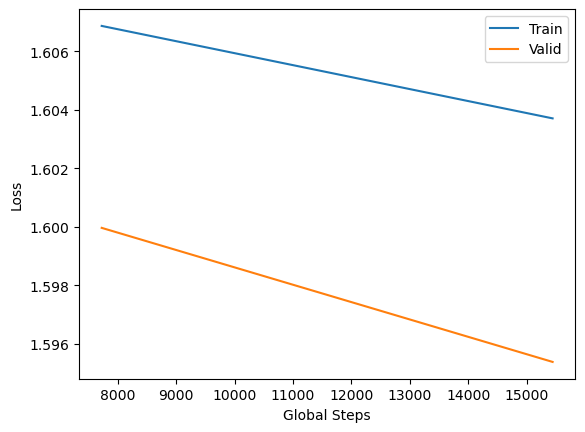

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation

In [ ]:
# Evaluation Function

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for sequences, lengths, labels in test_loader:
            labels = labels.to(device)
            sequences = sequences.to(device)
            # lengths = lengths.to(device)
            output = model(sequences, lengths)
            output = torch.argmax(output, dim=1)

            output = torch.round(output).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())

    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[0, 1, 2, 3, 4], digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['0', '1', '2', '3', '4'])
    ax.yaxis.set_ticklabels(['0', '1', '2', '3', '4'])

Model loaded from <== ./lstm/Model/model.pt
Classification Report:
              precision    recall  f1-score   support

           0     0.0131    0.2573    0.0249      1578
           1     0.0045    0.3515    0.0090       441
           2     0.0000    0.0000    0.0000      1692
           3     0.0000    0.0000    0.0000      5045
           4     0.9335    0.4613    0.6175    111616

    accuracy                         0.4324    120372
   macro avg     0.1902    0.2140    0.1303    120372
weighted avg     0.8658    0.4324    0.5729    120372



/home/calvin/anaconda3/envs/capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/calvin/anaconda3/envs/capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/calvin/anaconda3/envs/capstone/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

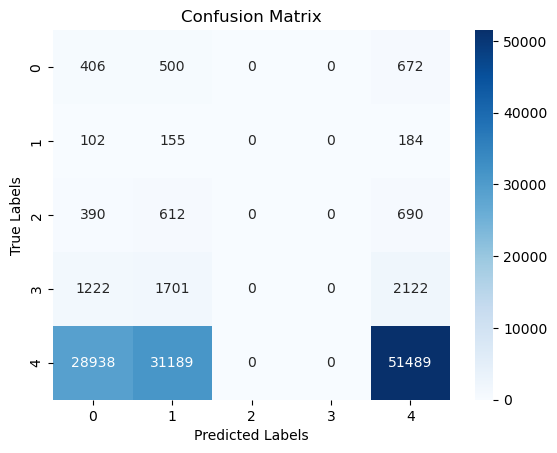

In [ ]:
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)